TLS test - based on Quickstart tutorial 01

In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams["figure.dpi"] = 200
import os
import batman as btm
# from bls import BLS
from astropy.stats import BoxLeastSquares as BLS
import bls
import transitleastsquares as tls
from astropy.io import fits as pyfits
import pyconstants as cst
np.random.seed(seed=0)  # reproducibility
# np.random.seed()

From the tutorial:     
"""     
To keep it as simple as possible, this first tutorial uses synthetic data.    
This gives the possibility to change the signal shape at will.     
It also avoids downloading and de-trending real data.     
We use the batman-package (Kreidberg 2015) to generate a planet around a solar-like star with a period of ~10 days.     
The dataset is 100 days long at a cadence of 30min (as with Kepler LC).     
We add 50ppm white noise per cadence.    
"""     
Init data:

In [9]:
# Create test data
time_start = 3.14
data_duration = 100.0
samples_per_day = 48
samples = int(data_duration * samples_per_day) # 48
time = np.linspace(time_start, time_start + data_duration, samples)

In [10]:
# Use batman to create transits
ma           = btm.TransitParams()
ma.t0        = time_start  # time of inferior conjunction; first transit is X days after start
ma.per       = 10.123  # orbital period
# ma.rp        = 6371.0 / 696342.0  # 6371 planet radius (in units of stellar radii)
ma.rp        = cst.Rjups  # 6371 planet radius (in units of stellar radii)
ma.a         = 19.0  # semi-major axis (in units of stellar radii)
ma.inc       = 90.0  # orbital inclination (in degrees)
ma.ecc       = 0.0  # eccentricity
ma.w         = 90.0  # longitude of periastron (in degrees)
ma.u         = [0.4, 0.4]  # limb darkening coefficients
ma.limb_dark = "quadratic"  # limb darkening model
m = btm.TransitModel(ma, time)  # initializes model
synthetic_signal = m.light_curve(ma)  # calculates light curve

In [11]:
# Create noise and merge with flux
ppm = 50.0  # Noise level in parts per million
noise = np.random.normal(loc=0.0, scale=10.0**-6 * ppm, size=int(samples))
flux = synthetic_signal + noise
eflux = np.zeros(np.shape(flux)) + 1.0e-5

Uses TESS lc

In [12]:
class lc:
    def __init__(self):
        self.file = None
        self.time_raw  = []
        self.flux_raw  = []
        self.eflux_raw = []
        self.q         = []
        self.time      = []
        self.flux_q    = []
        self.eflux_q   = []
        self.flux_med  = []
        self.filter    = []
        self.flux_n    = [] # corrected with spline/running median
        self.eflux_n   = []
        
    def read_fits(self, fits):
        self.name = os.path.basename(fits)
        hdu = pyfits.open(fits, mode='readonly')
        self.q   = hdu[1].data['QUALITY']
        self.time_raw  = hdu[1].data['TIME']
        self.flux_raw  = hdu[1].data['SAP_FLUX']
        self.eflux_raw = hdu[1].data['SAP_FLUX_ERR']
        hdu.close()
        okq = self.q == 0
        self.time = self.time_raw[okq]
        self.flux_q = self.flux_raw[okq]
        self.eflux_q = self.eflux_raw[okq]
        self.flux_med = np.median(self.flux_q)
    
    def running_median(self, win=1.0):
    
        x = self.time
        y = self.flux_q
        ey = self.eflux_q

        nx = np.shape(x)[0]
        z = np.ones((nx)) # filtered output
        xmin, xmax = np.min(x), np.max(x)
        hwin = 0.5*win
        for ix in range(0, nx):
            xs = x[ix]-hwin
            xe = x[ix]+hwin
            # first attempt to manage the starting/ending windows --> to be improved
            # 1) simple: take xmin/xmax as new lower/upper limits
            #if (xs < xmin):
            #    xs = xmin
            #elif(xe > xmax):
            #    xe = xmax 
            # 2) costant: take x[ix] values, counts how many points gt/lt x[ix] (nupper/nlower)
            #    and create nnew lower/upper missing values with y[ix] value
            if (xs < xmin):
                nup = int(np.sum(np.logical_and(x > x[ix], x <= xe)))
                nlow = int(np.sum(np.logical_and(x >= xs, x < x[ix])))
                nnew = int(np.abs(nup - nlow))
                #print 'xs < xmin: ', nup, nlow, nnew
                ylow = np.zeros((nnew)) + y[ix]
                selx = np.logical_and(x >= xs, x <= xe)
                ysel = np.hstack((ylow, y[selx]))
                nsel = np.shape(ysel)[0]
            elif(xe > xmax):
                nup = int(np.sum(np.logical_and(x > x[ix], x <= xe)))
                nlow = int(np.sum(np.logical_and(x >= xs, x < x[ix])))
                nnew = int(np.abs(nlow - nup))
                #print 'xe > xmax: ', nup, nlow, nnew
                yup = np.zeros((nnew)) + y[ix]
                selx = np.logical_and(x >= xs, x <= xe)
                ysel = np.hstack((y[selx], yup))
                nsel = np.shape(ysel)[0]
            else:
                selx = np.logical_and(x >= xs, x <= xe)
                nsel = int(np.sum(selx))
                if (nsel > 0): ysel = y[selx]

            if(nsel >0):
                z[ix] = np.median(ysel)
            else:
                z[ix] = np.nan

        self.filter = z
        self.flux_n = y / self.filter
        self.eflux_n = ey / np.median(self.filter)
    

In [13]:
# # TOI 125 = TIC 52368076
# tess_folder = os.path.abspath("/home/borsato/Temp/tess")
# fits1 = os.path.join(tess_folder, 
#         "MAST_2019-02-02T1317/TESS/tess2018206045859-s0001-0000000052368076-0120-s/tess2018206045859-s0001-0000000052368076-0120-s_lc.fits")
# fits2 = os.path.join(tess_folder, 
#         "MAST_2019-02-02T1317/TESS/tess2018234235059-s0002-0000000052368076-0121-s/tess2018234235059-s0002-0000000052368076-0121-s_lc.fits")
# fits = [fits1, fits2]
# lcs = []
# for f in fits:
#     olc = lc()
#     olc.read_fits(f)
#     olc.running_median(win=1.0)
#     lcs.append(olc)
# time = np.hstack((lcs[0].time,lcs[1].time))
# flux = np.hstack((lcs[0].flux_n, lcs[1].flux_n))
# eflux = np.hstack((lcs[0].eflux_n, lcs[1].eflux_n))

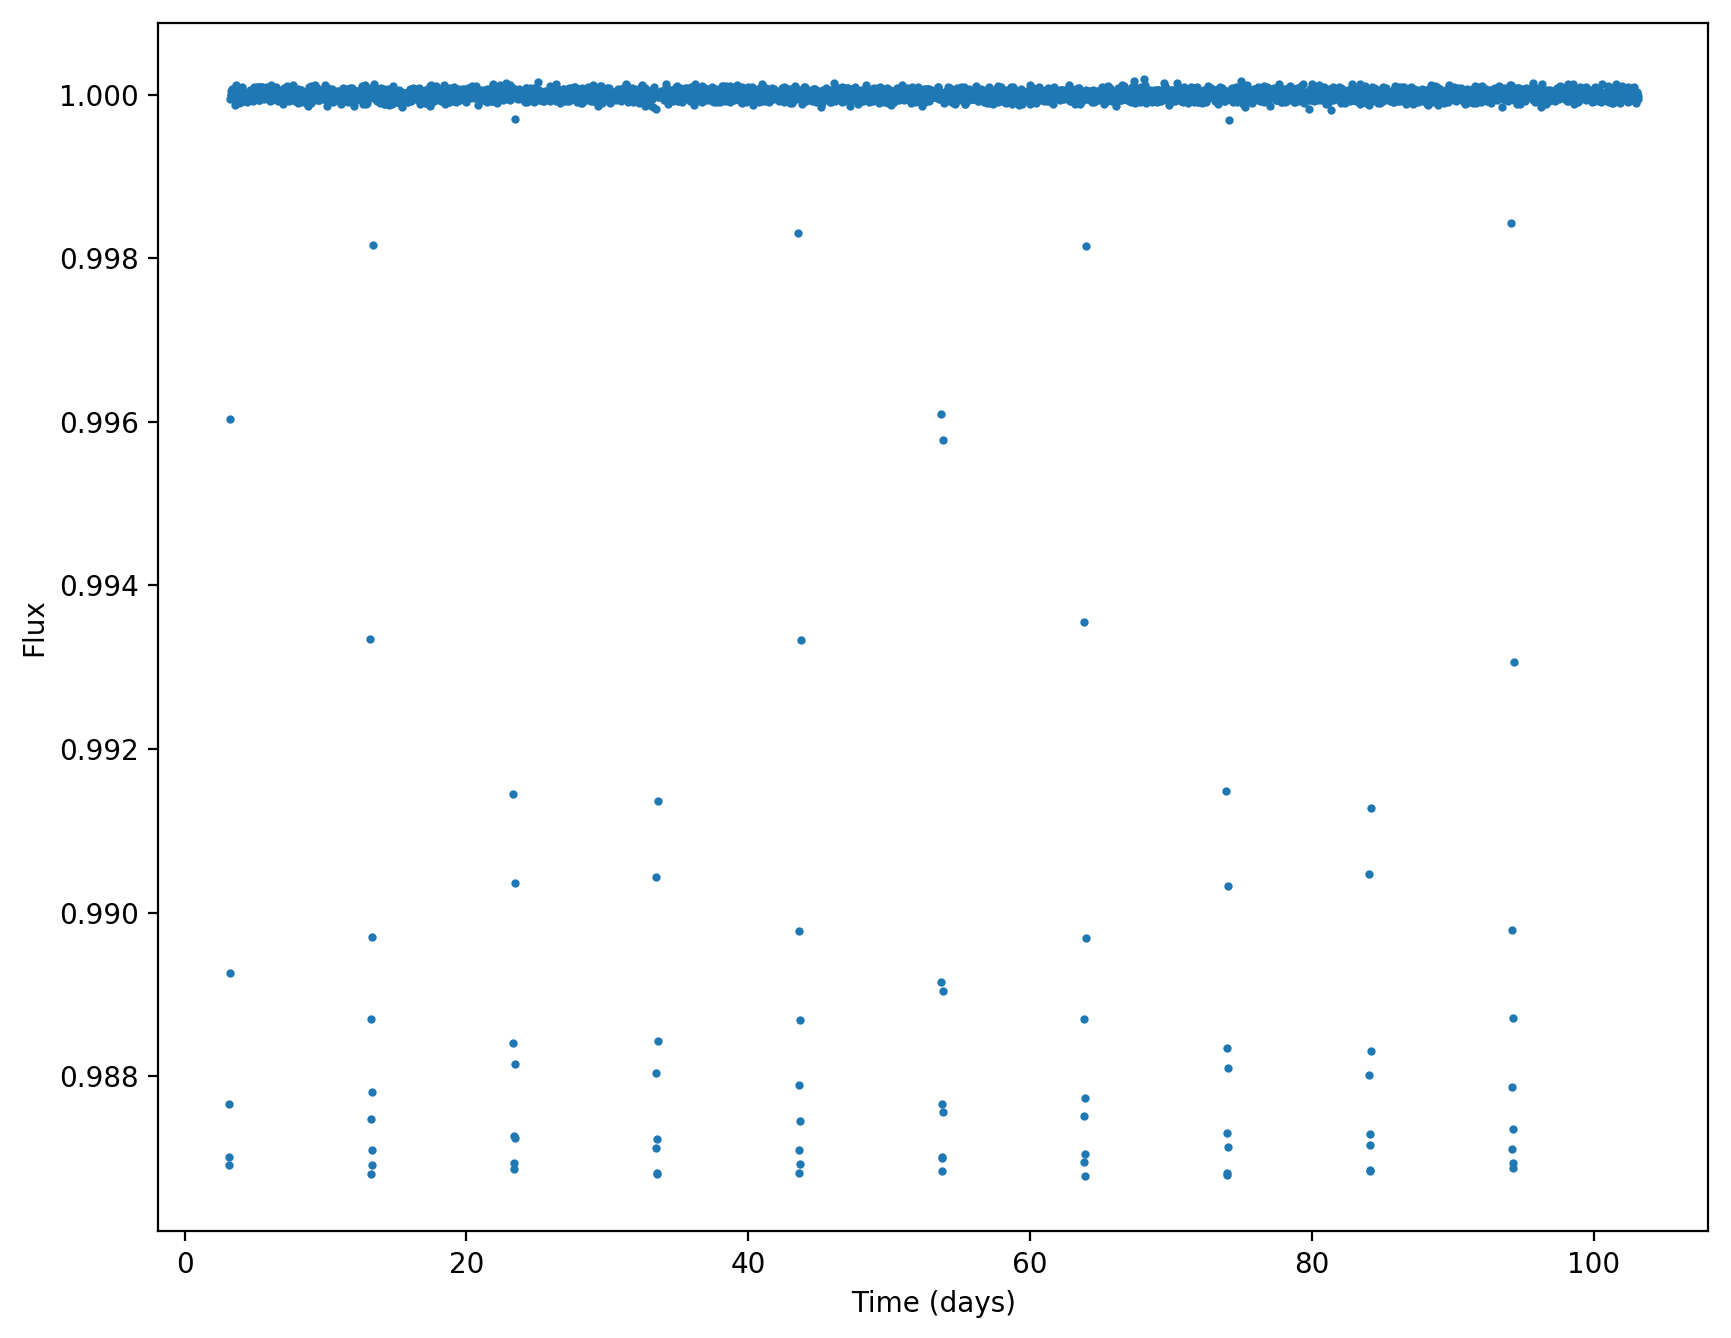

In [14]:
# Plot raw data
# plt.figure()
# ax = plt.gca()
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
# ax.plot(time, flux, color='C0', marker='o', ms=3, ls='')
ax.errorbar(time, flux, yerr=eflux,
            color='C0', ecolor='gray',
            fmt='o', ms=3, mec='None',
            ls='',
            capsize=0
           )
ax.set_ylabel("Flux")
ax.set_xlabel("Time (days)")
# plt.xlim(min(time), max(time))
# ax.set_ylim(0.9998, 1.0003)
plt.show()

In [15]:
# defines common stuf:
period_min = 0.99 # d
time_span = np.max(time)-np.min(time)
period_max = 0.75 * time_span
oversampling_factor=2
n_transits_min = 3
print('time span = {} ==> period max = {}'.format(time_span, period_max))
# kwargs = {"period_min":period_min,
#           "period_max":period_max,
#           "oversampling_factor":oversampling_factor,
#           "use_threads":1,
#           "n_transits_min":n_transits_min
#          }

time span = 100.0 ==> period max = 75.0


In [30]:
# TLS
# model = tls.transitleastsquares(time, flux, eflux)
# --> ValueError: No transit were fitted. Try smaller "transit_depth_min"
model = tls.transitleastsquares(time, flux)
# results = model.power(**kwargs)

ms = 0.93
rs = 0.87
pgrid = tls.period_grid(rs, ms, time_span,
                 period_min=0.1,
                  period_max=12.0
                 )
print(pgrid)
# compute fmax as in tls <-> Roche limit
fmax = np.sqrt(cst.Giau*ms/((3.0*rs*cst.RsunAU)**3))/(2.0*np.pi)
pmax = 1.0/fmax
print(fmax, pmax)
# results = model.power(period_min=0.5,
#                       period_max=11.0
#                      )

[11.99406999 11.98790421 11.98174265 ...  0.50638423  0.50629357
  0.50620293]
1.9731338404228236 0.506807992196672


In [19]:
# Summary results
print('Period {:.5f} d'.format(results.period))
print('{:d} transit times in time series:'.format(len(results.transit_times)), \
        ['{0:0.5f}'.format(i) for i in results.transit_times])
print('Transit depth {:.5f}'.format(1.0 - results.depth))
print('Best duration {:.5f} days = {:.3f} min'.format(results.duration, results.duration*1440.0))
print('Signal detection efficiency (SDE): {}'.format(results.SDE))

Period 10.12473 d
10 transit times in time series: ['3.14000', '13.26473', '23.38946', '33.51419', '43.63892', '53.76365', '63.88838', '74.01311', '84.13784', '94.26257']
Transit depth 0.01266
Best duration 0.17566 days = 252.954 min
Signal detection efficiency (SDE): 18.20353527473015


In [13]:
# Test with the astropy.stats -> BLS (Kovacs -> dfm implementation in bls.py)
m_bls = BLS(time, flux, dy=eflux)
per_in = results.periods
# durs = np.linspace(2.0*10/1440.0, per_in[0]*0.98, num=20, endpoint=True)
durs = np.linspace(2.0*10/1440.0, period_min*0.98, num=40, endpoint=True)
res_bls = m_bls.power(per_in, durs)

In [14]:
id_max = np.argmax(res_bls.power)
period = res_bls.period[id_max]
depth  = res_bls.depth[id_max]
dur    = res_bls.duration[id_max]
t0     = res_bls.transit_time[id_max] + period
tt     = res_bls.transit_time[id_max]
# Summary results
stats_bls = m_bls.compute_stats(period, dur, t0)
print('Period {:.5f} d'.format(period))
print('transit time: {} + period = {}'.format(tt, t0))
print('Transit depth {:.5f}'.format(depth))
print('Best duration {:.5f} days = {:.3f} min'.format(dur, dur*1440.0))
print('Stats:')
for k,v in stats_bls.items():
    print('{:s} = {}'.format(k, v))
# print('Signal detection efficiency (SDE): {}'.format(results.SDE))

Period 17.10114 d
transit time: 15.324713545555515 + period = 32.425854307543304
Transit depth 0.00134
Best duration 0.20972 days = 302.000 min
Stats:
transit_times = [1332.11255222 1349.21369298 1366.31483374]
per_transit_count = [146  47 148]
per_transit_log_likelihood = [-27.3863833  117.32659448 174.19622141]
depth = (0.0013350083723392414, 5.835526093118316e-05)
depth_phased = (-5.6483993379097264e-05, 5.073435482560013e-05)
depth_half = (0.0005411368269824246, 3.849279511341704e-05)
depth_odd = (0.0028108725038412663, 0.0001562692192730622)
depth_even = (0.0010980717523967343, 6.282481569455333e-05)
harmonic_amplitude = 4.15278145388202e-05
harmonic_delta_log_likelihood = -248.87227858883853


In [15]:
# BLS (dfm implementation in python-bls)
fmin, fmax = 1.0/per_in.max(), 1.0/per_in.min()
nf = np.shape(per_in)[0]
df = (fmax-fmin)/nf
qmi, qma = durs[0], durs[-1]
# nb = int(np.shape(time)[0]/10.0)
nb = 100
power_kbls, best_period_kbls, best_power_kbls, depth_kbls, q_kbls, in1, in2 = \
    bls.eebls(time, flux, np.zeros((len(time))), np.zeros((len(time))), nf, fmin, df, nb, qmi, qma)
dur_kbls = q_kbls * best_period_kbls

In [16]:
print('Fmin = {} (Pmax = {}) Fmax = {} (Pmin = {}) dF = {}'.format(fmin, per_in.max(), fmax, per_in.min(), df))
print('Period {:.5f} d'.format(best_period_kbls))
# print('transit time: {}'.format(tt))
print('Transit depth {:.5f}'.format(depth_kbls))
print('Best duration {:.5f} days = {:.3f} min'.format(dur_kbls, dur_kbls*1440.0))

Fmin = 0.05336371099368447 (Pmax = 18.739326433245033) Fmax = 1.0098583606350116 (Pmin = 0.9902378778853577) dF = 0.0003419716301899632
Period 14.12344 d
Transit depth inf
Best duration 14.12344 days = 20337.758 min


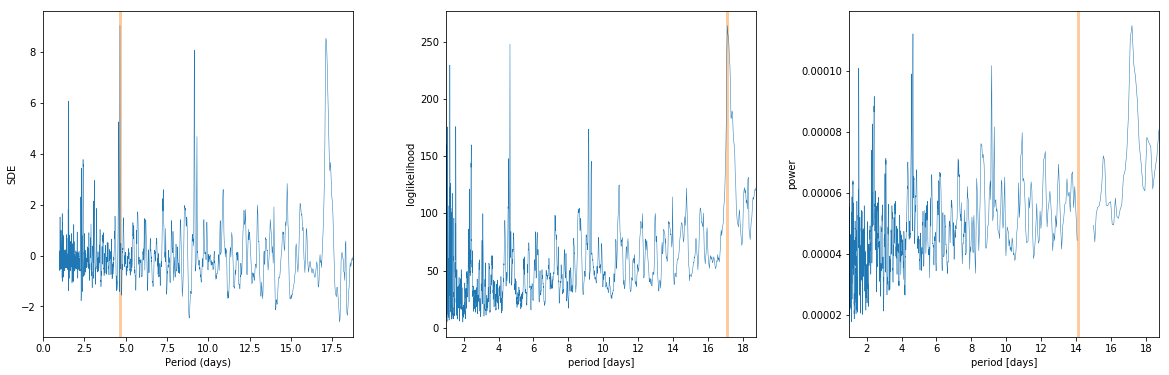

In [17]:
# Visualize the results:
# TLS
# Period vs SDE
# plt.figure()
# ax = plt.gca()
fig, ax = plt.subplots(1, 3, figsize=(20, 6))
fig.subplots_adjust(wspace=0.3)

ax[0].axvline(results.period, color='C1', alpha=0.4, lw=3)
ax[0].set_ylabel(r'SDE')
ax[0].set_xlabel('Period (days)')
ax[0].plot(results.periods, results.power, color='C0', lw=0.5)
ax[0].set_xlim(0, max(results.periods))

# BLS
# Period vs LogLikelihood
# Highlight the harmonics of the peak period
ax[1].axvline(period, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[1].plot(res_bls.period, res_bls.power, color='C0', lw=0.5)
ax[1].set_xlim(res_bls.period.min(), res_bls.period.max())
ax[1].set_ylabel(r'loglikelihood')
ax[1].set_xlabel("period [days]")

# BLS
# Period vs power
f_kbls = fmin + np.arange(nf) * df
p_kbls = 1.0/f_kbls
ax[2].axvline(best_period_kbls, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[2].plot(p_kbls, power_kbls, color='C0', lw=0.5)
ax[2].set_xlim(p_kbls.min(), p_kbls.max())
ax[2].set_ylabel(r'power')
ax[2].set_xlabel("period [days]")

plt.show()

In [ ]:
# TLS
# Freq vs SDE
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

freq_best = 1.0 / (results.period)
freq      = 1.0 / (results.periods)
ax[0].axvline(freq_best, color='C1', alpha=0.4, lw=3)
ax[0].set_ylabel(r'SDE')
ax[0].set_xlabel('Frequency (1/periods)')
ax[0].plot(freq, results.power, color='C0', lw=0.5)
ax[0].set_xlim(0.0, np.max(freq))

# BLS
# Frequency vs LogLikelihood
freq_best = 1.0 / (period)
freq      = 1.0 / (res_bls.period)
ax[1].axvline(freq_best, color='C1', alpha=0.4, lw=3)
# Plot the periodogram
ax[1].plot(freq, res_bls.power, color='C0', lw=0.5)
ax[1].set_xlim(0.0, freq.max())
ax[1].set_ylabel(r'loglikelihood')
ax[1].set_xlabel('Frequency (1/periods)')
plt.show()

In [ ]:
fig, ax = plt.subplots(2, 2, figsize=(20, 10))
# fig.subplots_adjust(wspace=0.3)
# TLS - data + transits

ax[0,0].set_title('TLS')
ax[0,0].plot(time, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[0,0].plot(results.model_lightcurve_time, results.model_lightcurve_model, color='C1', marker='None', ls='-', lw=1.5)
ax[0,0].set_xlabel('time (days)')
ax[0,0].set_ylabel('Relative flux')

ax[0,1].set_title('BLS')
tbls = np.linspace(time.min(), time.max(), 3*len(time))
fbls = m_bls.model(tbls, period, dur, t0)
ax[0,1].plot(time, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[0,1].plot(tbls, fbls, color='C1', marker='None', ls='-', lw=1.5)
ax[0,1].set_xlabel('time (days)')
ax[0,1].set_ylabel('Relative flux')

# folded lc
# TLS
ax[1,0].plot(results.folded_phase, results.folded_y, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[1,0].plot(results.model_folded_phase, results.model_folded_model, color='C1', marker='None', ls='-', lw=1.5)
ax[1,0].set_xlim(0.45, 0.55)
ax[1,0].set_xlabel('Phase')
ax[1,0].set_ylabel('Relative flux')
# # BLS
# ph_bls = ((time - tt) / period - np.floor((time - tt) / period) + 0.5)%1.0
ph_bls_d = (time - tt + 0.5*period) % period - 0.5*period
ph_bls = (ph_bls_d/period+0.5)%1.0
x_bls_d = np.linspace(-0.5, 0.5, 1000)
x_bls = (x_bls_d/period+0.5)%1.0
f_bls = m_bls.model(x_bls_d + tt, period, dur, tt)
# ax[1,1].plot((ph_bls/period+0.5)%1.0, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
# ax[1,1].plot((x_bls/period+0.5)%1.0, f_bls, color='C1', marker='None', ls='-', lw=1.5)
ax[1,1].plot(ph_bls, flux, color='C0', marker='o', mec='lightgray', mew=0.33, ms=5, ls='')
ax[1,1].plot(x_bls, f_bls, color='C1', marker='None', ls='-', lw=1.25)
ax[1,1].set_xlim(0.45, 0.55)
ax[1,1].set_xlabel('Phase')
ax[1,1].set_ylabel('Relative flux')

plt.show()